In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import execute


from typing import Optional, Union
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info.random import random_unitary
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library.generalized_gates.permutation import Permutation

In [6]:
print(np.empty((2,3,2)))

[[[1.01855798e-312 1.08221785e-312]
  [1.01855798e-312 9.54898106e-313]
  [1.18831764e-312 1.01855798e-312]]

 [[1.23075756e-312 1.08221785e-312]
  [1.08221785e-312 9.76118064e-313]
  [1.12465777e-312 1.90979621e-312]]]


In [7]:
def create_states_new(num_qubit):
    """Create states for the evolution."""
    out = np.empty(2**num_qubit,dtype='complex')
    for i in range(2**num_qubit):
        out[i] = np.array(np.random.uniform(-1, 1, 1) + 1.j * np.random.uniform(-1, 1, 1))
    
    out = out/np.sqrt(np.sum(np.abs(out)**2))
    return out

In [8]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2020.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Quantum Volume model circuit."""



class QuantumVolume(QuantumCircuit):
    """A quantum volume model circuit.

    The model circuits are random instances of circuits used to measure
    the Quantum Volume metric, as introduced in [1].

    The model circuits consist of layers of Haar random
    elements of SU(4) applied between corresponding pairs
    of qubits in a random bipartition.

    **Reference Circuit:**

    .. plot::

       from qiskit.circuit.library import QuantumVolume
       circuit = QuantumVolume(5, 6, seed=10)
       circuit.draw('mpl')

    **Expanded Circuit:**

    .. plot::

       from qiskit.circuit.library import QuantumVolume
       from qiskit.tools.jupyter.library import _generate_circuit_library_visualization
       circuit = QuantumVolume(5, 6, seed=10, classical_permutation=False)
       _generate_circuit_library_visualization(circuit.decompose())

    **References:**

    [1] A. Cross et al. Validating quantum computers using
    randomized model circuits, Phys. Rev. A 100, 032328 (2019).
    [`arXiv:1811.12926 <https://arxiv.org/abs/1811.12926>`_]
    """

    def __init__(
        self,
        num_qubits: int,
        depth: Optional[int] = None,
        seed: Optional[Union[int, np.random.Generator]] = None,
        classical_permutation: bool = True,
    ) -> None:
        """Create quantum volume model circuit of size num_qubits x depth.

        Args:
            num_qubits: number of active qubits in model circuit.
            depth: layers of SU(4) operations in model circuit.
            seed: Random number generator or generator seed.
            classical_permutation: use classical permutations at every layer,
                rather than quantum.
        """
        # Initialize RNG
        if seed is None:
            rng_set = np.random.default_rng()
            seed = rng_set.integers(low=1, high=1000)
        if isinstance(seed, np.random.Generator):
            rng = seed
        else:
            rng = np.random.default_rng(seed)

        # Parameters
        depth = depth or num_qubits  # how many layers of SU(4)
        width = int(np.floor(num_qubits / 2))  # how many SU(4)s fit in each layer
        name = "quantum_volume_" + str([num_qubits, depth, seed]).replace(" ", "")

        # Generator random unitary seeds in advance.
        # Note that this means we are constructing multiple new generator
        # objects from low-entropy integer seeds rather than pass the shared
        # generator object to the random_unitary function. This is done so
        # that we can use the integer seed as a label for the generated gates.
        unitary_seeds = rng.integers(low=1, high=1000, size=[depth, width])
        indices_of_gates = np.empty((depth,width,2))
        self.indices_of_gates = indices_of_gates
        # For each layer, generate a permutation of qubits
        # Then generate and apply a Haar-random SU(4) to each pair
        circuit = QuantumCircuit(num_qubits, name=name)
        self.circuit = circuit
        
        #circuit.initialize(create_states_new(num_qubits),circuit.qubits)
        circuit.initialize('0'*num_qubits)
        perm_0 = list(range(num_qubits))
        for d in range(depth):
            perm = rng.permutation(perm_0)
            if not classical_permutation:
                layer_perm = Permutation(num_qubits, perm)
                circuit.compose(layer_perm, inplace=True)
            for w in range(width):
                seed_u = unitary_seeds[d][w]
                su4 = random_unitary(4, seed=seed_u).to_instruction()
                su4.label = "su4_" + str(seed_u)
                if classical_permutation:
                    physical_qubits = int(perm[2 * w]), int(perm[2 * w + 1])
                    indices_of_gates[d][w] = physical_qubits
                    circuit.compose(su4, [physical_qubits[0], physical_qubits[1]], inplace=True)
                else:
                    circuit.compose(su4, [2 * w, 2 * w + 1], inplace=True)

        super().__init__(*circuit.qregs, name=circuit.name)
        self.compose(circuit.to_instruction(), qubits=self.qubits, inplace=True)

In [9]:
depth = 1
num_qubits = 4
width = int(np.floor(num_qubits / 2))
num_initial_states = 2**num_qubits
num_circuits = 1000
all_probs = np.empty((num_circuits,2**num_qubits))

QV = QuantumVolume(num_qubits, depth=depth)
backend = Aer.get_backend('statevector_simulator')
result = execute(QV.circuit, backend, shots=1000).result()
statevector = result.get_statevector(QV.circuit)
print(QV.indices_of_gates)
all_gates = QV.indices_of_gates
swaps = 0
for hey in np.reshape(all_gates,(depth*width,2)):
    swaps += 2*(np.abs(hey[0]-hey[1]) - 1)

QV.circuit.draw()

[[[1. 0.]
  [2. 3.]]]


┌──────────────────────┐┌──────────┐
q_0: ┤0                     ├┤1         ├
     │                      ││  su4_888 │
q_1: ┤1                     ├┤0         ├
     │  Initialize(0,0,0,0) │├──────────┤
q_2: ┤2                     ├┤0         ├
     │                      ││  su4_659 │
q_3: ┤3                     ├┤1         ├
     └──────────────────────┘└──────────┘

In [10]:
depth = 1
num_qubits = 5
width = int(np.floor(num_qubits / 2))
num_initial_states = 2**num_qubits
num_circuits = 1000
all_probs = np.empty((num_circuits,2**num_qubits))
all_swaps = np.empty(num_circuits)

for i in range(num_circuits):    
    QV = QuantumVolume(num_qubits, depth=depth)
    backend = Aer.get_backend('statevector_simulator')
    result = execute(QV.circuit, backend, shots=1000).result()
    all_gates = QV.indices_of_gates
    swaps = 0
    for hey in np.reshape(all_gates,(depth*width,2)):
        swaps += 2*(np.abs(hey[0]-hey[1]) - 1)
    all_swaps[i] = swaps
    statevector = result.get_statevector(QV.circuit)
    #print(np.abs(np.array(statevector))**2)
    prob = np.abs(np.array(statevector))**2
    all_probs[i] = prob

probs = all_probs.mean(axis=0)
print('wtf',all_probs.flatten(),all_probs.flatten().shape)

wtf [0.17553935 0.04050687 0.         ... 0.         0.         0.        ] (32000,)


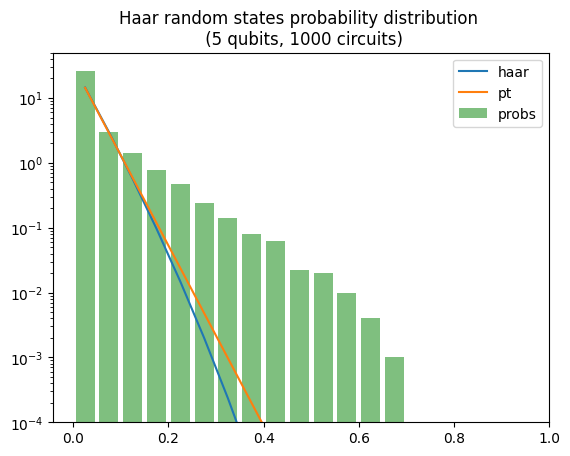

In [11]:
xplot = np.arange(0,1,0.05)
hist,bin_edges = np.histogram(all_probs.flatten(), bins = xplot)
bin_centers = np.array((bin_edges[:-1] + bin_edges[1:])/2)
plt.bar(bin_centers, hist/num_circuits, width = 0.04, color = 'g', alpha = 0.5, label='probs')
Haar_measure = (2**num_qubits -1)*(1-bin_centers)**(2**num_qubits -2)
pt_measure = 2**num_qubits*np.exp(-bin_centers*2**num_qubits)
plt.plot(bin_centers, Haar_measure, label='haar')
plt.plot(bin_centers,pt_measure, label='pt')
plt.yscale('log')
plt.ylim(1e-4, 5e1)
plt.xlim(None,1)
plt.title(f'Haar random states probability distribution \n ({num_qubits} qubits, {num_circuits} circuits)')
plt.legend()

## KAK Decomposition

In [26]:
from qiskit.quantum_info.synthesis import TwoQubitBasisDecomposer
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions.standard.cx import CnotGate

su4 = random_unitary(4)
op_su4 = Operator(su4)
q = QuantumRegister(2,'q')
qc = QuantumCircuit(q)

pauliXX = Pauli('XX')
XX = Operator(pauliXX)
decomposer = TwoQubitBasisDecomposer(CnotGate)

gates = decomposer.decomp1(op_su4)

print(gates)


ModuleNotFoundError: No module named 'qiskit.extensions.standard'

In [27]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer import AerSimulator

from qiskit.quantum_info.random import random_unitary
num_qubits = 2  # Adjust the number of qubits as needed
unitary_matrix = random_unitary(4).data

qc = QuantumCircuit(num_qubits)
qc.unitary(unitary_matrix, range(num_qubits))

basis_gates = ['u1', 'u2', 'u3', 'cx']  # Basis gates for decomposition
decomposed_circuit = transpile(qc, basis_gates=basis_gates)
print(decomposed_circuit)

global phase: 3.629
     ┌───────────────────────────┐        ┌──────────────────────┐       »
q_0: ┤ U3(1.2747,0.29858,-1.325) ├───■────┤ U3(0.55215,-π/2,π/2) ├────■──»
     ├───────────────────────────┴┐┌─┴─┐┌─┴──────────────────────┴─┐┌─┴─┐»
q_1: ┤ U3(1.4117,-0.10669,1.6681) ├┤ X ├┤ U3(2.5234,1.0414,2.6966) ├┤ X ├»
     └────────────────────────────┘└───┘└──────────────────────────┘└───┘»
«         ┌───────────────────┐         ┌───────────────────────────┐
«q_0: ────┤ U3(0.46979,0,π/2) ├──────■──┤ U3(1.7197,-2.2511,2.1943) ├
«     ┌───┴───────────────────┴───┐┌─┴─┐├───────────────────────────┤
«q_1: ┤ U3(1.8545,-1.8806,3.0522) ├┤ X ├┤ U3(1.2218,-1.0459,2.9601) ├
«     └───────────────────────────┘└───┘└───────────────────────────┘


In [30]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer import AerSimulator

from qiskit.quantum_info.random import random_unitary
num_qubits = 2  # Adjust the number of qubits as needed

#Define your SU(4) unitary matrix
unitary_matrix = random_unitary(4).data

# Create a quantum circuit with the unitary matrix
qc = QuantumCircuit(num_qubits)
qc.unitary(unitary_matrix, range(num_qubits))

# Choose your target basis. In this case you want to decompose into CNOT gates and single qubit gates
basis_gates = ['u1', 'u2', 'u3', 'cx']  # Basis gates for decomposition

#Use qiskit's transpile function to decompose the circuit into the desired basis
decomposed_circuit = transpile(qc, basis_gates=basis_gates)

print(decomposed_circuit)

# Visualize the decomposed circuit
decomposed_circuit.draw()


#You can simulate the decomposed circuit to verify its correctness
# simulator = AerSimulator()
# result = simulator.run(decomposed_circuit).result()
# final_state = result.get_statevector()
# plot_bloch_multivector(final_state)

#This code will generate a random SU(4) unitary, decompose it into CNOT gates
# and single-qubit gates, and allow you to visualize and verify the result. Make sure
# to adjust the number of qubits and other parameters as needed for your specific case.


global phase: 0.82985
     ┌───────────────────────────┐       ┌──────────────────────┐      »
q_0: ┤ U3(2.1107,-1.0131,3.0706) ├──■────┤ U3(0.70994,-π/2,π/2) ├───■──»
     └┬─────────────────────────┬┘┌─┴─┐┌─┴──────────────────────┴┐┌─┴─┐»
q_1: ─┤ U3(2.3,-2.0371,-2.3552) ├─┤ X ├┤ U3(2.2242,1.1933,2.905) ├┤ X ├»
      └─────────────────────────┘ └───┘└─────────────────────────┘└───┘»
«        ┌──────────────────────┐         ┌──────────────────────────┐ 
«q_0: ───┤ U3(0.014131,-π,-π/2) ├────■────┤ U3(1.7361,-0.49,-1.4256) ├─
«     ┌──┴──────────────────────┴─┐┌─┴─┐┌─┴──────────────────────────┴┐
«q_1: ┤ U3(1.8545,-1.8806,3.0522) ├┤ X ├┤ U3(0.47948,-0.23444,2.6907) ├
«     └───────────────────────────┘└───┘└─────────────────────────────┘


global phase: 0.82985
     ┌───────────────────────────┐       ┌──────────────────────┐      »
q_0: ┤ U3(2.1107,-1.0131,3.0706) ├──■────┤ U3(0.70994,-π/2,π/2) ├───■──»
     └┬─────────────────────────┬┘┌─┴─┐┌─┴──────────────────────┴┐┌─┴─┐»
q_1: ─┤ U3(2.3,-2.0371,-2.3552) ├─┤ X ├┤ U3(2.2242,1.1933,2.905) ├┤ X ├»
      └─────────────────────────┘ └───┘└─────────────────────────┘└───┘»
«        ┌──────────────────────┐         ┌──────────────────────────┐ 
«q_0: ───┤ U3(0.014131,-π,-π/2) ├────■────┤ U3(1.7361,-0.49,-1.4256) ├─
«     ┌──┴──────────────────────┴─┐┌─┴─┐┌─┴──────────────────────────┴┐
«q_1: ┤ U3(1.8545,-1.8806,3.0522) ├┤ X ├┤ U3(0.47948,-0.23444,2.6907) ├
«     └───────────────────────────┘└───┘└─────────────────────────────┘